In [3]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
train_df = pd.read_csv('../dump/train_modified.csv')
test_df = pd.read_csv('../dump/test_modified.csv')

In [5]:
target='acc_now_delinq'
IDcol = 'member_id'
train_df[target].value_counts()

0.0    706610
1.0      3293
Name: acc_now_delinq, dtype: int64

In [26]:
label=train_df['acc_now_delinq']
train_df=train_df.drop(['acc_now_delinq'],axis=1)
train_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,8875.0,8875.0,8875.0,36,18.25,321.97,3,17,9.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,16700.0,NaN,NaN,NaN
1,12500.0,12500.0,12475.0,36,8.90,396.92,0,4,2.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33600.0,33600.0,33600.0,60,18.55,863.31,4,21,10.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,41300.0,NaN,NaN,NaN
3,17000.0,17000.0,17000.0,60,9.71,358.78,1,5,12.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,22800.0,NaN,NaN,NaN
4,14000.0,14000.0,14000.0,60,16.99,347.87,3,17,6.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,10300.0,NaN,NaN,NaN


In [59]:
# test_results = pd.read_csv('test_results.csv')
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['acc_now_delinq'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['acc_now_delinq'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['acc_now_delinq'], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
#     results = test_results.merge(dtest[['ID','predprob']], on='ID')
#     print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [6]:
predictors = [x for x in train_df.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)
# modelfit(xgb1, train_df, test_df, predictors)

In [8]:
useTrainCV=True;cv_folds=5;early_stopping_rounds=50
alg=xgb1
dtrain=train_df; dtest=test_df
if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    xgtest = xgb.DMatrix(dtest[predictors].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
    alg.set_params(n_estimators=cvresult.shape[0])
    
#Fit the algorithm on the data
alg.fit(dtrain[predictors], dtrain['acc_now_delinq'],eval_metric='auc')

#Predict training set:
dtrain_predictions = alg.predict(dtrain[predictors])
dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

[0]	train-auc:0.655883+0.0376047	test-auc:0.65245+0.0383701
[1]	train-auc:0.753439+0.0187471	test-auc:0.746119+0.0200461
[2]	train-auc:0.792536+0.00811801	test-auc:0.784083+0.0111021
[3]	train-auc:0.805684+0.00664292	test-auc:0.795037+0.0106495
[4]	train-auc:0.809345+0.00759135	test-auc:0.797649+0.0115639
[5]	train-auc:0.809987+0.00985569	test-auc:0.797914+0.010452
[6]	train-auc:0.813661+0.00887173	test-auc:0.80087+0.0115972
[7]	train-auc:0.814928+0.00817615	test-auc:0.802717+0.00911607
[8]	train-auc:0.819787+0.00384295	test-auc:0.809699+0.00657045
[9]	train-auc:0.822614+0.00526921	test-auc:0.81187+0.00554564
[10]	train-auc:0.824507+0.00547189	test-auc:0.813316+0.00670853
[11]	train-auc:0.827624+0.00447283	test-auc:0.81828+0.00491762
[12]	train-auc:0.830897+0.0025271	test-auc:0.820097+0.00552255
[13]	train-auc:0.831695+0.0036408	test-auc:0.82008+0.00417376
[14]	train-auc:0.832039+0.00285998	test-auc:0.82019+0.00478594
[15]	train-auc:0.832884+0.00389173	test-auc:0.820348+0.00413479
[16]

C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9965
Recall:0.9965
AUC Score (Train): 0.942435


Text(0,0.5,'Feature Importance Score')

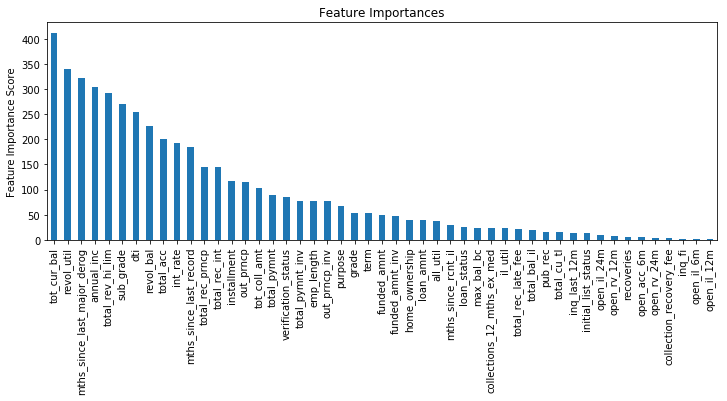

In [9]:
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['acc_now_delinq'].values, dtrain_predictions))
print("Recall:%.4g"% metrics.accuracy_score(dtrain['acc_now_delinq'].values, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['acc_now_delinq'], dtrain_predprob))

#     Predict on testing data:
dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
#     results = test_results.merge(dtest[['ID','predprob']], on='ID')
#     print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))

feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
y_score = alg.decision_function(X_test)

In [10]:
dtest['predprob']

0         0.007568
1         0.005681
2         0.000742
3         0.000011
4         0.000902
5         0.000699
6         0.002110
7         0.000108
8         0.004160
9         0.007893
10        0.004587
11        0.000071
12        0.001193
13        0.001028
14        0.002584
15        0.002313
16        0.000004
17        0.001855
18        0.000668
19        0.002774
20        0.002117
21        0.000073
22        0.007932
23        0.000499
24        0.002403
25        0.001924
26        0.002400
27        0.009154
28        0.000685
29        0.001175
            ...   
177446    0.004168
177447    0.004174
177448    0.001547
177449    0.011776
177450    0.030996
177451    0.043153
177452    0.000542
177453    0.001627
177454    0.000973
177455    0.004913
177456    0.001530
177457    0.000695
177458    0.000077
177459    0.001422
177460    0.000664
177461    0.000752
177462    0.001041
177463    0.004562
177464    0.005298
177465    0.007032
177466    0.003597
177467    0.

In [11]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, dtest['predprob'])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

NameError: name 'y_test' is not defined